# Object detection benchmark

This notebook will run benchmarks for HW and SW implementations of QNN.

# Detection

Declare constants.

In [1]:
# Storage configuration
DATA_PATH = "data"
IMG_PATH = f"{DATA_PATH}/img"
SAMPLE_IMAGE_PATH = f"{IMG_PATH}/friends.jpg"
BENCH_DATA_PATH = "data"
BENCH_FILE = f"{BENCH_DATA_PATH}/object_detection_benchmark.txt"
PICKLE_PATH = f"{BENCH_DATA_PATH}/pickle"
PICKLE_FILE = f"{PICKLE_PATH}/detections.pkl"

BENCH_PATH =  f"{DATA_PATH}/benchmarks"
BENCH_FILE = f"{BENCH_PATH}/object_detection_bench.json"

ITERATIONS = 100

# Python module configuration
DARKNET_PATH = "/opt/darknet"
PYTHON_PATH = "/usr/local/lib/python3.6"
PYTHON_PKG_PATH = f"{PYTHON_PATH}/dist-packages"
QNN_PATH = f"{PYTHON_PKG_PATH}/qnn"

# Classifier configurations
QNN_SIZE = 416  # width and height of images used by YoloV2
QNN_THRESHOLD = 0.3  # certainty that there is an object in a box
                     # lower -> more results
QNN_THRESHOLD_HIER = 0.5  # threshold to consider a class in a box
                          # 0: follow the most certain path until a leaf node

Import QNN, Darknet and other required modules.
A [custom version of darknet](https://github.com/giuliogamba/darknet) is installed in `/opt/darknet` when running the `setup.py` of QNN.

This notebook uses a [fork I made](https://github.com/mikelsr/darknet) of a current version of darknet with the required changes made for the QNN version.

In [2]:
import qnn
from qnn import TinierYolo, utils

import array
import ctypes
import cv2
import json
import numpy as np
import os
from PIL import Image, ImageOps
import sys
from time import time

sys.path.append(f"{DARKNET_PATH}/python")
import darknet

from matplotlib import pyplot as plt
%matplotlib inline

The same image as in the notebook will be used.

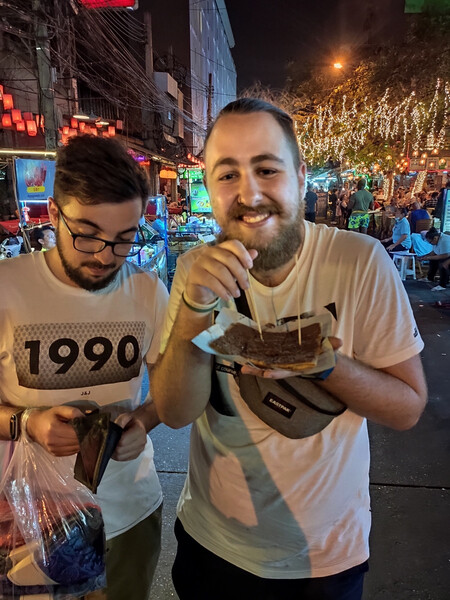

In [3]:
sample_image = Image.open(SAMPLE_IMAGE_PATH)
W, H = sample_image.size
sample_image

Create folder to store benchmarks and output files.

In [4]:
try:
    os.makedirs(BENCH_PATH)
except FileExistsError:
    pass

Create variables that will be used by both SW and HW classifications.

In [5]:
bench = {
    "sw": [],
    "hw": []
}

file_name_cfg = ctypes.c_char_p(f"{QNN_PATH}/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = darknet.lib.parse_network_cfg(file_name_cfg)

# Classification function

## Load the QNN classifier

The QNN classifier will be used to identify people in an image.

In [6]:
def classify(runtime="python_hw", img_path=SAMPLE_IMAGE_PATH, iterations=1):
    
    # variable used to store benchmarks
    keyword = "hw" if runtime == "python_hw" else "sw"

    start = time()
    classifier = TinierYolo(runtime=runtime)
    classifier.init_accelerator()
    net = classifier.load_network(json_layer=f"{QNN_PATH}/params/tinier-yolo-layers.json")

    conv0_weights = np.load(f"{QNN_PATH}/params/tinier-yolo-conv0-W.npy",
                            encoding="latin1", allow_pickle=True)
    conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
    conv8_weights = np.load(f"{QNN_PATH}/params/tinier-yolo-conv8-W.npy",
                            encoding="latin1", allow_pickle=True)
    conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
    conv0_bias = np.load(f"{QNN_PATH}/params/tinier-yolo-conv0-bias.npy",
                         encoding="latin1", allow_pickle=True)
    conv0_bias_broadcast = np.broadcast_to(conv0_bias[:, np.newaxis],
                                           (net["conv1"]["input"][0],
                                            net["conv1"]["input"][1] * net["conv1"]["input"][1]))
    conv8_bias = np.load(f"{QNN_PATH}/params/tinier-yolo-conv8-bias.npy",
                         encoding="latin1", allow_pickle=True)
    conv8_bias_broadcast = np.broadcast_to(conv8_bias[:, np.newaxis], (125, 13*13))
    
    end = time()
    micros = int((end - start) * 1e6)
    print(f"Loading the classifier took {micros} microseconds")
    
    img_raw = darknet.load_image(ctypes.c_char_p(img_path.encode()), 0, 0)
    img_letterbox = darknet.letterbox_image(img_raw, QNN_SIZE, QNN_SIZE)
    img = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3, QNN_SIZE, QNN_SIZE)))
    _img = np.swapaxes(img, 0, 2)

    # Store original dimensions of the image
    W, H = img_raw.w, img_raw.h
    
    last_conv = None
    for i in range(iterations):
        print(f"\rIteration: {i+1}", end="")
        start = time()
        img = _img[np.newaxis, :, :, :]
        conv0_ouput = utils.conv_layer(img, conv0_weights_correct,
                                       b=conv0_bias_broadcast,
                                       stride=2, padding=1)
        conv0_output_quant = conv0_ouput.clip(0.0, 4.0)
        conv0_output_quant = utils.quantize(conv0_output_quant/4, 3)

        end = time()
        micros = int((end - start) * 1e6)
        first = micros
        out_ch = net['conv7']['output'][0]
        out_dim = net['conv7']['output'][1]

        conv_output = classifier.get_accel_buffer(out_ch, out_dim)
        conv_input = classifier.prepare_buffer(conv0_output_quant*7);

        # Run actual layers
        start = time()
        classifier.inference(conv_input, conv_output)
        end = time()
        conv7_out = classifier.postprocess_buffer(conv_output)


        micros = int((end - start) * 1e6)
        middle = micros
        start = time()

        conv7_out_reshaped = conv7_out.reshape(out_dim, out_dim, out_ch)
        conv7_out_swapped = np.swapaxes(conv7_out_reshaped, 0, 1) # exp 1
        conv7_out_swapped = conv7_out_swapped[np.newaxis, :, :, :] 

        conv8_output = utils.conv_layer(conv7_out_swapped, conv8_weights_correct,
                                        b=conv8_bias_broadcast,stride=1)  
        conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

        end = time()
        micros = int((end - start) * 1e6)
        last = micros
        bench[keyword].append((first, middle, last))
        if i == iterations - 1:
            last_conv = conv8_out
    classifier.deinit_accelerator()
    print()
    first_avg, middle_avg, last_avg = 0, 0, 0
    for x in bench[keyword]:
        first_avg += x[0]
        middle_avg += x[1]
        last_avg += x[2]
    first_avg = first_avg//len(bench[keyword])
    middle_avg = middle_avg//len(bench[keyword])
    last_avg = last_avg//len(bench[keyword])
    print("Time averages ({}):\n  First: {}\n  Middle: {}\n  Last: {}"
          .format(keyword, first_avg, middle_avg, last_avg))
    return last_conv

## Run HW version

Prepare sample image.

In [7]:
classify("python_hw", iterations=ITERATIONS)

hw_total_times = [sum(x) for x in bench["hw"]]
# times of the hardware layer only
hw_hw_times = [x[1] for x in bench["hw"]]
# times of the software layers only
hw_sw_times = [int(x[0] + x[2]) for x in bench["hw"]]

print(f"MAX HW time: {max(hw_total_times)} microseconds")
print(f"AVG HW time: {sum(hw_total_times)//ITERATIONS} microseconds")
print(f"MIN HW time: {min(hw_total_times)} microseconds")

print(f"MAX HW core layers time: {max(hw_hw_times)}")
print(f"AVG HW core layers time: {sum(hw_hw_times)//ITERATIONS} microseconds")
print(f"MIN HW core layers time: {min(hw_hw_times)} microseconds")

print(f"MAX HW border layers time: {max(hw_sw_times)} microseconds")
print(f"AVG HW border layers time: {sum(hw_sw_times)//ITERATIONS} microseconds")
print(f"MIN HW border layers time: {min(hw_sw_times)} microseconds")

/usr/local/lib/python3.6/dist-packages/pynq/pl_server/device.py:641: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)


Loading the classifier took 500633 microseconds
Iteration: 100
Time averages (hw):
  First: 207487
  Middle: 103678
  Last: 44523
MAX HW time: 375325 microseconds
AVG HW time: 355689 microseconds
MIN HW time: 344274 microseconds
MAX HW core layers time: 105271
AVG HW core layers time: 103678 microseconds
MIN HW core layers time: 100896 microseconds
MAX HW border layers time: 270054 microseconds
AVG HW border layers time: 252010 microseconds
MIN HW border layers time: 242576 microseconds


## Run SW version

In [8]:
# conv8_out = classify("python_sw", iterations=ITERATIONS)

In [9]:
meta = darknet.load_meta(ctypes.c_char_p(f"{DARKNET_PATH}/cfg/voc.data".encode()))
img_raw = darknet.load_image(ctypes.c_char_p(SAMPLE_IMAGE_PATH.encode()), 0, 0)

times = []
for i in range(ITERATIONS):
    print(f"\rIteration: {i+1}", end="")
    start = time()
    darknet.classify_nosort(net_darknet, meta, img_raw)
    end = time()
    micros = int((end - start) * 1e6)
    times.append(micros)
print()
sw_max = max(times)
sw_avg = sum(times)//ITERATIONS
sw_min = min(times)

print(f"MAX SW time: {sw_max} microseconds")
print(f"AVG SW time: {sw_avg} microseconds")
print(f"MIN SW time: {sw_min} microseconds")

Iteration: 100
MAX SW time: 9594506 microseconds
AVG SW time: 8845280 microseconds
MIN SW time: 8320766 microseconds


## Save results

In [10]:
results = {
    "hw": {
        "total": hw_total_times,
        "hw": hw_hw_times,
        "sw": hw_sw_times
    },
    "sw": times
}
with open(BENCH_FILE, 'w') as f:
    f.write(json.dumps(results))

# Cleanup

In [11]:
from pynq import Xlnk

xlnk = Xlnk()
xlnk.xlnk_reset()

## Load results

In [2]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

results = {}
with open(BENCH_FILE, 'r') as f:
    results = json.loads(f.read())

hw_total_times = results["hw"]["total"]
hw_hw_times = results["hw"]["hw"]
hw_sw_times = results["hw"]["sw"]

sw_avg = sum(results["sw"])//len(results["sw"])
sw_max = max(results["sw"])
sw_min = min(results["sw"])

## HW and SW comparison

Compare the total times of SW+HW and SW.

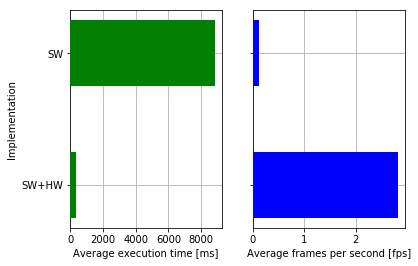

In [3]:
labels = ["SW+HW", "SW"]

fig, (a1, a2) = plt.subplots(1, 2, sharex="col", sharey="row",figsize=(10,3))
x_pos = np.arange(len(labels))

_hw_avg = sum(hw_total_times)//ITERATIONS
_sw_avg = sw_avg

plt.yticks(x_pos, labels)
a1.invert_yaxis()
a1.set_xlabel("Average execution time [ms]")
a1.set_ylabel("Implementation")
a1.barh(x_pos, (_hw_avg/1000, _sw_avg/1000), height=0.5, color="g", zorder=3)
a1.grid(zorder=0)

a2.invert_yaxis()
fps = (1/(_hw_avg/1e6), 1/(_sw_avg/1e6))
a2.set_xlabel("Average frames per second [fps]")
a2.barh(x_pos, fps, color="b", height=0.5, zorder=3)
a2.grid(zorder=0)

plt.show()

First and last layers vs middle layers

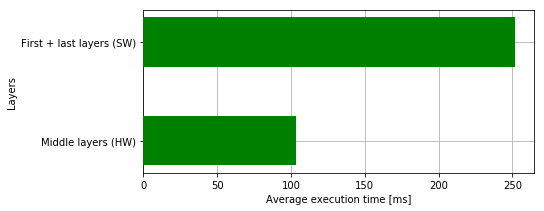

In [7]:
labels = ["First + last layers (SW)", "Middle layers (HW)"]

fig, (a1) = plt.subplots(1, 1, sharex="col", sharey="row",figsize=(7,3))
x_pos = np.arange(len(labels))

_hw_avg = sum(hw_hw_times)//ITERATIONS
_sw_avg = sum(hw_sw_times)//ITERATIONS

plt.yticks(x_pos, labels)
a1.invert_yaxis()
a1.set_xlabel("Average execution time [ms]")
a1.set_ylabel("Layers")
a1.barh(x_pos, (_sw_avg/1000, _hw_avg/1000), height=0.5, color="g", zorder=3)
a1.grid(zorder=0)

plt.show()

Variation comparison

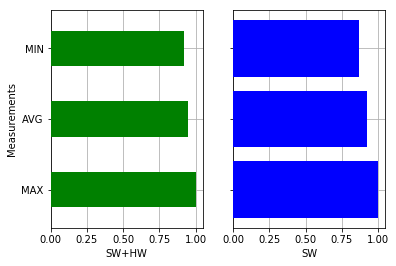

In [4]:
labels = ["MAX", "AVG", "MIN"]

fig, (a1, a2) = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(10,3))
x_pos = np.arange(len(labels))

# normalize data to range [1, 0]
_hw_max = 1.0
_hw_avg = sum(hw_total_times)/ITERATIONS/max(hw_total_times)
_hw_min = min(hw_total_times)/max(hw_total_times)

_sw_max = 1.0
_sw_avg = sw_avg/sw_max
_sw_min = sw_min/sw_max

plt.yticks(x_pos, labels)
a1.invert_yaxis()
a1.set_xlabel("SW+HW")
a1.set_ylabel("Measurements")
a1.barh(x_pos, (_hw_max, _hw_avg, _hw_min), height=0.5, color="g", zorder=3)
a1.grid(zorder=0)

a2.invert_yaxis()
fps = (1/(_hw_avg/1e6), 1/(_sw_avg/1e6))
a2.set_xlabel("SW")
a2.barh(x_pos, (_sw_max, _sw_avg, _sw_min), color="b", zorder=3)
a2.grid(zorder=0)

plt.show()